In [1]:
#Importing packages
import praw
import requests
import pandas as pd
import json
from datetime import datetime, timedelta, date

#Configs for API keys
from config import reddit_client_id
from config import reddit_secret_key
from config import reddit_user_name
from config import reddit_password
from config import yahoo_api_key

#Graphs, math, and stats
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy.stats import linregress
from scipy import stats

In [2]:
#Base URL for rapidapi yahoo finance
yahoo_base_url = "https://yahoo-finance127.p.rapidapi.com/price/"

#API key and host
headers_yahoo = {
    "X-RapidAPI-Key": yahoo_api_key,
    "X-RapidAPI-Host": "yahoo-finance127.p.rapidapi.com"
}

#get input from user for stock symbol / empty list 
company_names = []
stock_symbol = str(input("Enter stock symbol to search"))

#------------------------------------------------------------------------TO-DO - Add error handling for when ticker is not found
#Grabbing URL, stock symbol, converting to JSON
yahoo_response = requests.get(yahoo_base_url + stock_symbol, headers=headers_yahoo).json()
#yahoo_response

#Add longname as search term for reddit
company_names.append(yahoo_response["longName"])

#Add stock symbol as search term for reddit
company_names.append(stock_symbol)

#Get alternate company names to use for reddit search
msg = f"{stock_symbol}'s LongName is {company_names[0]}.  Add another search term and press Enter, or press Cancel when done'"

#While loop to add company name
while True:
    response = str(input(msg))
    if len(response)> 0:
        company_names.append(response)
    else:
        break

#remove duplicates from company_names
reddit_search_list = pd.Series(company_names).drop_duplicates().tolist()

In [3]:
#Checking reponse from rapid API
print(yahoo_response)

{'symbol': 'TSLA', 'twoHundredDayAverageChangePercent': {'raw': 0.12031461, 'fmt': '12.03%'}, 'fiftyTwoWeekLowChangePercent': {'raw': 1.4875749, 'fmt': '148.76%'}, 'averageAnalystRating': '2.8 - Hold', 'language': 'en-US', 'regularMarketDayRange': {'raw': '252.56 - 258.74', 'fmt': '252.56 - 258.74'}, 'earningsTimestampEnd': {'raw': 1706529600, 'fmt': '2024-01-29', 'longFmt': '2024-01-29T07:00'}, 'epsForward': {'raw': 3.5, 'fmt': '3.50'}, 'regularMarketDayHigh': {'raw': 258.74, 'fmt': '258.74'}, 'twoHundredDayAverageChange': {'raw': 27.198502, 'fmt': '27.20'}, 'twoHundredDayAverage': {'raw': 226.0615, 'fmt': '226.06'}, 'askSize': {'raw': 8, 'fmt': '8', 'longFmt': '8'}, 'bookValue': {'raw': 16.818, 'fmt': '16.82'}, 'fiftyTwoWeekHighChange': {'raw': -46.030014, 'fmt': '-46.03'}, 'marketCap': {'raw': 805093244928, 'fmt': '805.093B', 'longFmt': '805,093,244,928'}, 'fiftyTwoWeekRange': {'raw': '101.81 - 299.29', 'fmt': '101.81 - 299.29'}, 'fiftyDayAverageChange': {'raw': 19.862991, 'fmt': '1

In [4]:
#Grabbing function method to access reddit
auth = requests.auth.HTTPBasicAuth(reddit_client_id,reddit_secret_key)
data = {
    'grant_type': 'password',
    'username': reddit_user_name,
    'password': reddit_password
}
headers = {'User-Agent': 'redditapi/1'}
#Grabbing posts from reddit
res = requests.post('https://www.reddit.com/api/v1/access_token',
                    auth=auth, data=data, headers=headers)
token12 = res.json()['access_token']
headers = {**headers, **{'Authorization': f'bearer {token12}'}}
headers
requests.get('https://oauth.reddit.com/api/v1/me', headers=headers)
#Creating empty list to store reddit posts
reddit_posts = []

#Activating Praw
reddit = praw.Reddit(
    client_id=reddit_client_id,
    client_secret=reddit_secret_key,
    password = data['password'],
    user_agent=f"testscript by u/{data['username']}",
    username = data['username'],
)


#-----------------------------------------------------------TO-DO: Do we need to set a different limit or search criteria?
#Using praw to get subreddit easily
for term in reddit_search_list:
    for submission in reddit.subreddit("wallstreetbets").search(term, limit=50, sort="new"):
        sub_create_utc = datetime.utcfromtimestamp(submission.created_utc).strftime('%Y-%m-%d') 
        reddit_posts.append({"search term": term,
                             "title": submission.title,
                            "upvotes": submission.score,
                            "num_comments": submission.num_comments,
                            "date_utc": sub_create_utc})
#Creating Dataframe
reddit_df = pd.DataFrame(reddit_posts)
reddit_df.drop_duplicates(subset=["title"],keep="first",inplace=True)
reddit_df

,search term,title,upvotes,num_comments,date_utc
0,"Tesla, Inc.","RIVN GAIN, DIAMOND HANDS",96,37,2023-12-14
1,"Tesla, Inc.",JPOW looking at job data today,10,1,2023-12-08
2,"Tesla, Inc.",Where is all the damn gain porn?,35,37,2023-12-07
3,"Tesla, Inc.",TSLA Institutional Ownership Over Time.,10,5,2023-11-28
4,"Tesla, Inc.",Tesla insiders had perfect timing with selling...,90,27,2023-11-20
...,...,...,...,...,...
94,tsla,Fisker (FSR) YOLO Update - 11/13/2023,80,127,2023-11-13
95,tsla,"TSLA Bulls and bears, Make sure you pay attent...",12,6,2023-11-09
96,tsla,RIVN Earnings: Time to Hit it Big,5,37,2023-11-07
97,tsla,Is NVO actually Overvalued?,10,24,2023-11-04


In [5]:
#Prepping Yahoo Rapid API for JSON print
url = f"https://yahoo-finance127.p.rapidapi.com/historic/{stock_symbol}/1d/1000d"
#Printing yahoo Rapid API 
yahoo_response2 = requests.get(url,headers=headers_yahoo).json()
yahoo_response2

{'meta': {'currency': 'USD',
  'symbol': 'TSLA',
  'exchangeName': 'NMS',
  'instrumentType': 'EQUITY',
  'firstTradeDate': 1277818200,
  'regularMarketTime': 1702928345,
  'gmtoffset': -18000,
  'timezone': 'EST',
  'exchangeTimezoneName': 'America/New_York',
  'regularMarketPrice': 253.159,
  'chartPreviousClose': 28.692,
  'priceHint': 2,
  'currentTradingPeriod': {'pre': {'timezone': 'EST',
    'start': 1702890000,
    'end': 1702909800,
    'gmtoffset': -18000},
   'regular': {'timezone': 'EST',
    'start': 1702909800,
    'end': 1702933200,
    'gmtoffset': -18000},
   'post': {'timezone': 'EST',
    'start': 1702933200,
    'end': 1702947600,
    'gmtoffset': -18000}},
  'dataGranularity': '1d',
  'range': '1000d',
  'validRanges': ['1d',
   '5d',
   '1mo',
   '3mo',
   '6mo',
   '1y',
   '2y',
   '5y',
   '10y',
   'ytd',
   'max']},
 'timestamp': [1577716200,
  1577802600,
  1577975400,
  1578061800,
  1578321000,
  1578407400,
  1578493800,
  1578580200,
  1578666600,
  1578

In [6]:
#Empty list to store yahoo finance data
yahoo_finance3 = []
#Creating loop to create add data to list
x = 0
for date_data in yahoo_response2['timestamp']:
    formatted_date = datetime.utcfromtimestamp(yahoo_response2['timestamp'][x]).strftime('%Y-%m-%d') 
    
    yahoo_finance3.append({"Symbol": yahoo_response2['meta']["symbol"],
                        "date_utc": formatted_date,
                        "Open": yahoo_response2['indicators']['quote'][0]['open'][x],
                        "Volume": yahoo_response2['indicators']['quote'][0]['volume'][x],
                        "High": yahoo_response2['indicators']['quote'][0]['high'][x],
                        "Close": yahoo_response2['indicators']['quote'][0]['close'][x],
                        "Low": yahoo_response2['indicators']['quote'][0]['low'][x]})
    
    x += 1

#Creating dataframe from list
yahoo_finance3_df = pd.DataFrame(yahoo_finance3)

#Finding Daily Change price from "close" and "open" price
yahoo_finance3_df["Daily Change"] = yahoo_finance3_df["Close"] - yahoo_finance3_df["Open"]
print(yahoo_finance3_df)


    Symbol    date_utc        Open     Volume        High       Close  \
0     TSLA  2019-12-30   28.586000  188796000   28.600000   27.646667   
1     TSLA  2019-12-31   27.000000  154285500   28.086000   27.888666   
2     TSLA  2020-01-02   28.299999  142981500   28.713333   28.684000   
3     TSLA  2020-01-03   29.366667  266677500   30.266666   29.534000   
4     TSLA  2020-01-06   29.364668  151995000   30.104000   30.102667   
..     ...         ...         ...        ...         ...         ...   
995   TSLA  2023-12-12  238.550003   95328300  238.990005  237.009995   
996   TSLA  2023-12-13  234.190002  146286300  240.300003  239.289993   
997   TSLA  2023-12-14  241.220001  160829200  253.880005  251.050003   
998   TSLA  2023-12-15  251.210007  135720800  254.130005  253.500000   
999   TSLA  2023-12-18  253.779999   93075555  258.739990  253.158798   

            Low  Daily Change  
0     27.284000     -0.939333  
1     26.805332      0.888666  
2     28.114000      0.3840

In [7]:
#Merging the reddit data and yahoo finance data
merged_df = pd.merge(reddit_df,yahoo_finance3_df)
merged_df = merged_df.sort_values(by='date_utc')
merged_df

,search term,title,upvotes,num_comments,date_utc,Symbol,Open,Volume,High,Close,Low,Daily Change
52,"Tesla, Inc.",2022 u/GlideOutside “margin: never again.” 202...,297,152,2023-06-08,TSLA,224.220001,164489700,235.229996,234.860001,223.009995,10.639999
51,"Tesla, Inc.",$TSLA chart,28,24,2023-06-15,TSLA,248.399994,160171200,258.950012,255.899994,247.289993,7.500000
50,"Tesla, Inc.",$FSR Shorts Don't Stand a Chance,33,59,2023-06-26,TSLA,250.070007,179990600,258.369995,241.050003,240.699997,-9.020004
49,"Tesla, Inc.",Time to secure profits and sell everything or ...,107,120,2023-06-28,TSLA,249.699997,159770800,259.880005,256.239990,248.889999,6.539993
48,"Tesla, Inc.",Tesla float getting close to 0,0,38,2023-06-30,TSLA,260.600006,112267600,264.450012,261.769989,259.890015,1.169983
...,...,...,...,...,...,...,...,...,...,...,...,...
0,"Tesla, Inc.","RIVN GAIN, DIAMOND HANDS",96,37,2023-12-14,TSLA,241.220001,160829200,253.880005,251.050003,240.789993,9.830002
1,tsla,Quoting After a Win,6,2,2023-12-14,TSLA,241.220001,160829200,253.880005,251.050003,240.789993,9.830002
2,tsla,"Today was great, but…",3,94,2023-12-14,TSLA,241.220001,160829200,253.880005,251.050003,240.789993,9.830002
54,tsla,Tesla to cut prices again in 2024? TSLA Poots?,7,24,2023-12-15,TSLA,251.210007,135720800,254.130005,253.500000,248.300003,2.289993


In [8]:
#Removing huge outliers from reddit upvotes and comments
merged_df = merged_df[(np.abs(stats.zscore(merged_df['upvotes'])) < 3)]
merged_df = merged_df[(np.abs(stats.zscore(merged_df['num_comments'])) < 3)]
merged_df

,search term,title,upvotes,num_comments,date_utc,Symbol,Open,Volume,High,Close,Low,Daily Change
52,"Tesla, Inc.",2022 u/GlideOutside “margin: never again.” 202...,297,152,2023-06-08,TSLA,224.220001,164489700,235.229996,234.860001,223.009995,10.639999
51,"Tesla, Inc.",$TSLA chart,28,24,2023-06-15,TSLA,248.399994,160171200,258.950012,255.899994,247.289993,7.500000
50,"Tesla, Inc.",$FSR Shorts Don't Stand a Chance,33,59,2023-06-26,TSLA,250.070007,179990600,258.369995,241.050003,240.699997,-9.020004
49,"Tesla, Inc.",Time to secure profits and sell everything or ...,107,120,2023-06-28,TSLA,249.699997,159770800,259.880005,256.239990,248.889999,6.539993
48,"Tesla, Inc.",Tesla float getting close to 0,0,38,2023-06-30,TSLA,260.600006,112267600,264.450012,261.769989,259.890015,1.169983
...,...,...,...,...,...,...,...,...,...,...,...,...
0,"Tesla, Inc.","RIVN GAIN, DIAMOND HANDS",96,37,2023-12-14,TSLA,241.220001,160829200,253.880005,251.050003,240.789993,9.830002
1,tsla,Quoting After a Win,6,2,2023-12-14,TSLA,241.220001,160829200,253.880005,251.050003,240.789993,9.830002
2,tsla,"Today was great, but…",3,94,2023-12-14,TSLA,241.220001,160829200,253.880005,251.050003,240.789993,9.830002
54,tsla,Tesla to cut prices again in 2024? TSLA Poots?,7,24,2023-12-15,TSLA,251.210007,135720800,254.130005,253.500000,248.300003,2.289993


52    167.479030
51    207.274997
50    179.187072
49    207.918081
48    218.377764
         ...    
0     198.101511
1     198.101511
2     198.101511
54    202.735543
53    202.090179
Name: Close, Length: 80, dtype: float64
1.8914439117298203
y = 1.89x +-276.75
The r-value is: 0.005201750867772966


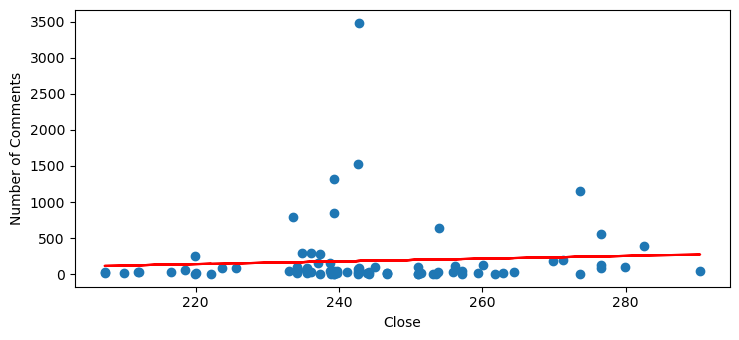

In [23]:
# Linear regression on Reddit upvotes and comments, yahoo prices
x_values = merged_df['Close']
y_values = merged_df['upvotes']

# Perform a linear regression on X and Y
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)

# Get regression values
regress_values = x_values * slope + intercept
print(regress_values)
print(slope)
#Creating line equation
line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))
print(line_eq)
# Create Plot
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")

# Label plot and annotate the line equation
plt.xlabel('Close')
plt.ylabel('Number of Comments')
plt.annotate(line_eq,(20,5),fontsize=15,color="red")

# Print r value
print(f"The r-value is: {rvalue**2}")

# Show plot
plt.show()

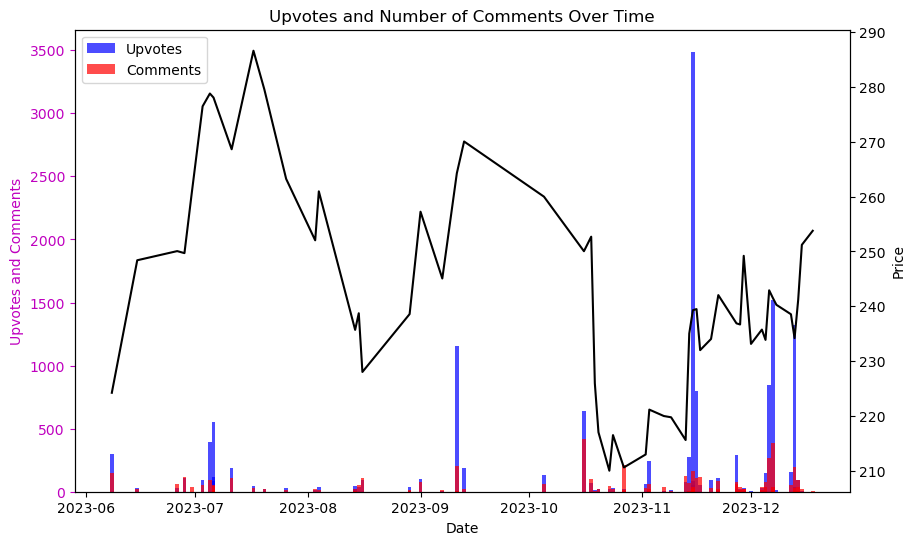

In [14]:

merged_df['date_utc'] = pd.to_datetime(merged_df['date_utc'])
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.bar(merged_df['date_utc'], merged_df['upvotes'], color='b', alpha=0.7, label='Upvotes', width=1)
ax1.bar(merged_df['date_utc'], merged_df['num_comments'], color='r', alpha=0.7, label='Comments', width=1)
ax1.set_xlabel('Date')
ax1.set_ylabel('Upvotes and Comments', color='m')
ax1.tick_params('y', colors='m')
ax2 = ax1.twinx()
ax2.plot(merged_df['date_utc'], merged_df['Open'], color='k', label='Price')
ax2.set_ylabel('Price', color='k')
ax2.tick_params('y', colors='k')

leg = ax1.legend(loc ="upper left")

plt.title('Upvotes and Number of Comments Over Time')
plt.show()

In [ ]:
# Example of the Spearman's Rank Correlation Test
from scipy.stats import spearmanr
data1 = merged_df['upvotes']
data2 = merged_df['num_comments']
stat, p = spearmanr(data1, data2)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
 print('Probably independent')
else:
 print('Probably dependent')

stat=0.714, p=0.000
Probably dependent
